In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("punkt")
import nltk
nltk.data.path.clear()  # Clear all search paths (just in case)

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/stock_data.csv")
data.head()

Mounted at /content/drive


,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [4]:
# Check for missing values
print("Missing values per column:\n", data.isnull().sum())

Missing values per column:
 Text         0
Sentiment    0
dtype: int64


In [5]:
# Check unique sentiment values
print("Unique Sentiment Values:", data["Sentiment"].unique())

Unique Sentiment Values: [ 1 -1]


In [6]:
# Basic statistics of numerical features
print(data.describe())

         Sentiment
count  5791.000000
mean      0.272664
std       0.962192
min      -1.000000
25%      -1.000000
50%       1.000000
75%       1.000000
max       1.000000


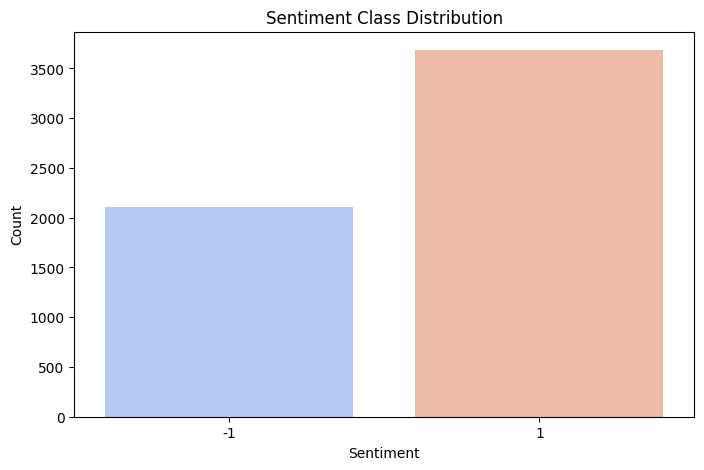

Sentiment
 1    3685
-1    2106
Name: count, dtype: int64


In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x=data["Sentiment"], palette="coolwarm")
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Print count for each sentiment
print(data["Sentiment"].value_counts())


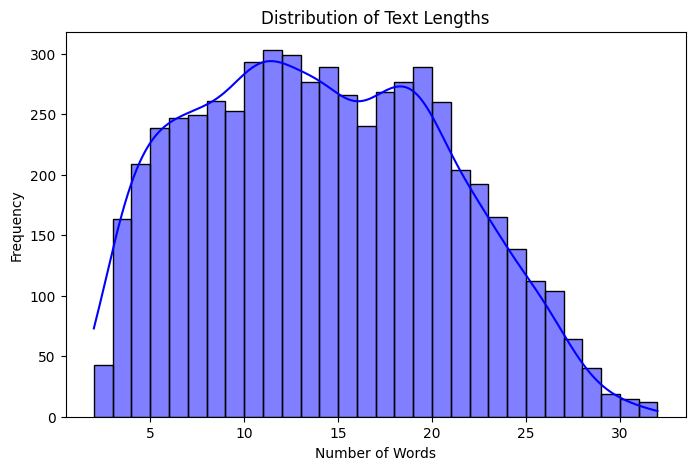

In [8]:
data["Text_Length"] = data["Text"].apply(lambda x: len(x.split()))  # Count words per text

# Plot histogram of text lengths
plt.figure(figsize=(8,5))
sns.histplot(data["Text_Length"], bins=30, kde=True, color="blue")
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


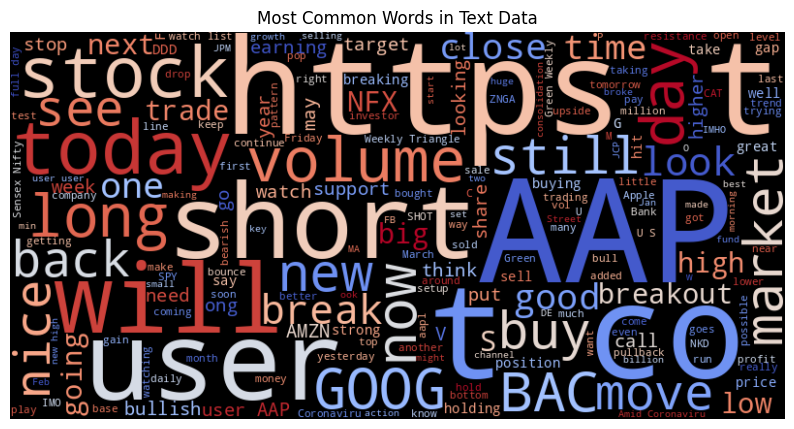

In [9]:
# Combine all text data
text_corpus = " ".join(data["Text"])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="coolwarm").generate(text_corpus)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Text Data")
plt.show()


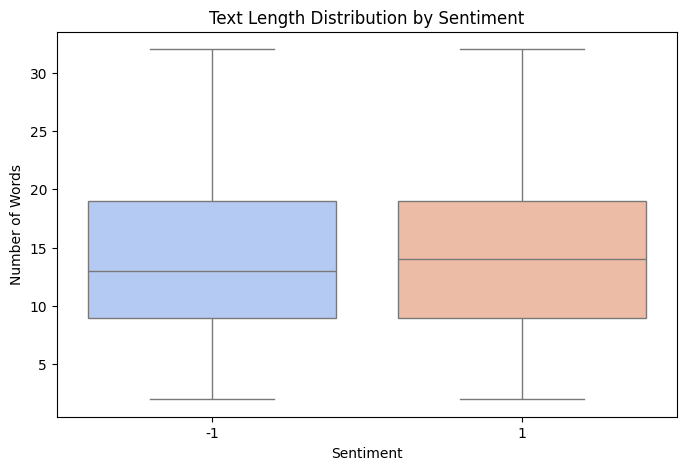

In [10]:
plt.figure(figsize=(8,5))
sns.boxplot(x=data["Sentiment"], y=data["Text_Length"], palette="coolwarm")
plt.title("Text Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Text         5791 non-null   object
 1   Sentiment    5791 non-null   int64 
 2   Text_Length  5791 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 135.9+ KB


In [12]:
# Disable wandb logging
import os
os.environ["WANDB_DISABLED"] = "true"

# Imports
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers.trainer_callback import PrinterCallback

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load your dataset
data = pd.read_csv("/content/drive/MyDrive/stock_data.csv")

# Filter and map sentiment
data = data[data['Sentiment'].isin([-1, 1])].copy()
data['Sentiment'] = data['Sentiment'].map({-1: 0, 1: 1}).astype(int)

# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Text'].tolist(),
    data['Sentiment'].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize using FinBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Load FinBERT model with 2 output classes
model = AutoModelForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-tone",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # manually loop through 3 epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Remove default logs to reduce clutter
trainer.remove_callback(PrinterCallback)

# Manual loop for 3 epochs, printing each epoch's results
epoch_stats = []

for epoch in range(1, 4):
    print(f"\nEpoch {epoch}")

    # Train for one epoch
    trainer.train(resume_from_checkpoint=None)

    # Capture training loss
    train_logs = trainer.state.log_history
    last_loss = next((log['loss'] for log in reversed(train_logs) if 'loss' in log), 0.0)

    # Evaluate
    result = trainer.evaluate()

    # Save metrics
    epoch_stats.append([
        epoch,
        round(last_loss, 6),
        round(result.get('eval_loss', 0), 6),
        round(result.get('eval_accuracy', 0), 6),
        round(result.get('eval_precision', 0), 6),
        round(result.get('eval_recall', 0), 6),
        round(result.get('eval_f1', 0), 6)
    ])

    # Print after every epoch
    print("Epoch\tTraining Loss\tValidation Loss\tAccuracy\tPrecision\tRecall\tF1")
    print(f"{epoch}\t{last_loss:.6f}\t{result['eval_loss']:.6f}\t"
          f"{result['eval_accuracy']:.6f}\t{result['eval_precision']:.6f}\t"
          f"{result['eval_recall']:.6f}\t{result['eval_f1']:.6f}")

# Final summary table
print("\nFinal Summary:")
print("Epoch\tTraining Loss\tValidation Loss\tAccuracy\tPrecision\tRecall\tF1")
for row in epoch_stats:
    print(f"{row[0]}\t{row[1]:.6f}\t{row[2]:.6f}\t{row[3]:.6f}\t{row[4]:.6f}\t{row[5]:.6f}\t{row[6]:.6f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Epoch 1


Step,Training Loss
10,0.676700
20,0.627900
30,0.641300
40,0.591100
50,0.551700
60,0.531300
70,0.536000
80,0.539600
90,0.536200
100,0.500700


Epoch	Training Loss	Validation Loss	Accuracy	Precision	Recall	F1
1	0.482600	0.430670	0.809318	0.811206	0.909836	0.857695

Epoch 2


Step,Training Loss
10,0.427800
20,0.398100
30,0.349500
40,0.440400
50,0.309400
60,0.307800
70,0.231600
80,0.236200
90,0.318200
100,0.186300


Epoch	Training Loss	Validation Loss	Accuracy	Precision	Recall	F1
2	0.485200	0.440108	0.813632	0.823308	0.897541	0.858824

Epoch 3


Step,Training Loss
10,0.439700
20,0.297100
30,0.229600
40,0.236500
50,0.139100
60,0.104200
70,0.097000
80,0.100500
90,0.045700
100,0.003300


Epoch	Training Loss	Validation Loss	Accuracy	Precision	Recall	F1
3	0.737200	0.612628	0.810181	0.832468	0.875683	0.853529

Final Summary:
Epoch	Training Loss	Validation Loss	Accuracy	Precision	Recall	F1
1	0.482600	0.430670	0.809318	0.811206	0.909836	0.857695
2	0.485200	0.440108	0.813632	0.823308	0.897541	0.858824
3	0.737200	0.612628	0.810181	0.832468	0.875683	0.853529


In [ ]:
# Disable WandB logging (to prevent API key prompt)
import os
os.environ["WANDB_DISABLED"] = "true"

# Imports
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    BertTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/stock_data.csv")

# Preprocess sentiments to binary (0, 1)
data = data[data['Sentiment'].isin([-1, 1])].copy()
data['Sentiment'] = data['Sentiment'].map({-1: 0, 1: 1}).astype(int)

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Text'].tolist(),
    data['Sentiment'].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenize using FinBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

# Load FinBERT with a 2-class classification head
model = AutoModelForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-tone",
    num_labels=2,
    ignore_mismatched_sizes=True
)

# Metrics function for Trainer
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define training arguments
ttraining_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # manually loop through 3 epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2
)

# Setup the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate best model on validation set
eval_results = trainer.evaluate()
print("\n Final Evaluation Metrics:")
for key, value in eval_results.items():
    print(f"{key}: {value:.6f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-tone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,0.677000
20,0.623100
30,0.632400
40,0.615100
50,0.562800
60,0.530500
70,0.555800
80,0.552100
90,0.533700
100,0.487000


In [14]:
!pip install -U transformers

